<a href="https://colab.research.google.com/github/actionsolve/article25/blob/master/20200400_Webcam_acquire_and_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo Webcam Acquisition and Image Classification

## Instructions to Run
1. Ensure this notebook is open in Google colab hosting (ie. check the URL starts with: 'https://colab.research.google.com/...')
1. Scroll to the last cell, so the title '**Run**' is visible
1. Click on the last cell
1. Run the entire notebook, by typing: CTRL + F9
  - It may take a minute to run.  
  - You should then see somne buttons and a live image from your webcam
1. Follow instructions from supporting acticle: "**How to Train Your Webcam**"

  
    

## Imports

In [1]:
# Force TF version
# 2020-04-14: %tensorflow_version 1.x    -> Tensorflow ver: 1.15.2     +  TF.Keras  ver: 2.2.4-tf  + Keras  ver: 2.3.1
# 2020-04-14: %tensorflow_version 2.x    -> Tensorflow ver: 2.2.0-rc2  +  TF.Keras  ver: 2.3.0-tf  + Keras  ver: 2.3.1
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Imports
import datetime as dt  ; 
import os
import sys              ; print(f'Python        ver: %s.%s.%s   %s' % (*sys.version_info[0:3], sys.platform))
import threading
import time

from cv2 import *       ; print(f'OpenCV        ver: {cv2.__version__}')
import numpy as np      ; print(f'Numpy         ver: {np.__version__}')
import pandas as pd     ; print(f'Pandas        ver: {pd.__version__}')

import ipywidgets as widgets
#from ipywidgets import Button, GridBox, Layout, ButtonStyle
from google.colab import widgets as colab_widgets  #  For working tabs

from IPython.display import Image, HTML, display, display_html, Javascript, Markdown, clear_output
#from PIL import Image                            XXX BEWARE also using Image from HTML
from google.colab.output import eval_js
from base64 import b64decode

import PIL
import io
from base64 import b64encode

if False: 
    import tensorflow as tf          ; print(f'Tensorflow    ver: {tf.__version__}' )  # native: ver: 2.2.0-rc1
    import tensorflow.keras as keras ; print(f'Keras         ver: {keras.__version__}' )  #  ver: 2.2.4-tf

    #from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.models import model_from_json
    # from tensorflow.keras import models, layers

    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    from tensorflow.keras.applications import vgg16
    from tensorflow.keras import backend as K

    #import tensorflow.python.util.deprecation as deprecation

else:
    import tensorflow as tf ; print(f'Tensorflow    ver: {tf.__version__}' )  # native: ver: 2.2.0-rc1
    import keras            ; print(f'Keras         ver: {keras.__version__}' )  # native ver: 2.2.5

    #from keras.layers import Input, Dense
    from keras.models import model_from_json

    from keras.preprocessing.image import load_img, img_to_array
    from keras.preprocessing.image import ImageDataGenerator

    from keras.applications import vgg16
    #from keras.applications import nasnet
    from keras import backend as K

    #K.tensorflow_backend._SYMBOLIC_SCOPE.value = True

    #import tensorflow.python.util.deprecation as deprecation
    

Python        ver: 3.6.9   linux
OpenCV        ver: 4.1.2
Numpy         ver: 1.18.2
Pandas        ver: 1.0.3
Tensorflow    ver: 1.15.2
Keras         ver: 2.3.1


Using TensorFlow backend.


In [0]:
!/bin/rm -f  ~/.keras/models/*

## Tools - Image Acquisition and Display


In [0]:
# Webcam acquisition tools
# Heavily plaguarised from https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=buJCl90WhNfq
def get_html_live_video(width=640, height=480):
    """
    Get HTML tag for live video display from webcam
    """
    html_video_tag = f'<video id="video" width="{width}" height="{height}" autoplay></video>'
    html_video_start_js = """
    <script>
        // Display webcam in video tag.  No audio required
        if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
            navigator.mediaDevices.getUserMedia({ video: true, audio: false }).then(function(stream) {
                let video = document.getElementById('video');
                video.srcObject = stream;
                video.play();
            });
        }
    </script>
    """
    # return HTML(html_video_tag + html_video_js)
    return html_video_tag + html_video_start_js

def acquire_webcam_image_to_file(filename, image_dims=(640, 480), quality=0.8, verbose=False):
    """
    Acquire image to file
    """
    js = Javascript('''
        async function takePhoto(quality) {

            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Draw video image to canvas, to capture
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            // Stop video
            stream.getVideoTracks()[0].stop();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data_jpeg_base64 = eval_js(f'takePhoto({quality})')
    tokens = data_jpeg_base64.split(',')
    if(verbose): print(f'    Acquired {len(tokens[1])} bytes, type: {tokens[0]}')
    bytes_jpeg = b64decode(data_jpeg_base64.split(',')[1])
    image = PIL.Image.open(io.BytesIO(bytes_jpeg))  # ; print(image.size) 

    # Resize
    (old_width, old_height) = image.size
    (new_width, new_height) = image_dims
    if( (old_width != new_width) or (old_height != new_height) ):
        if(verbose): print(f'    Resizing image {old_width} x {old_height}  ->  {new_width} x {new_height}')
        image = image.resize(image_dims, PIL.Image.ANTIALIAS) #; print(image.size)

    # Save to file
    image.save(filename, optimize=True, quality=75)
    if(verbose): print(f'    Saved to {filename}    {image.size[0]} x {image.size[1]}')
    return filename, new_width, new_height

def stop_live_webcam_video():
    js = Javascript('''
        function stop_video() {
            console.log("Stopping HTML video, via JS " );
            const video = document.getElementById('video');
            const stream = video.srcObject;
            stream.getVideoTracks().forEach(track => track.stop());
        }
    ''')
    display(js)
    eval_js(f'stop_video()')
    
# Test acquire images to file
if False:
    try:
        print('Started')
        # Show live video
        display(HTML(get_html_live_video(width=100, height=100))) 

        # Acquire from webcam
        filename, img_width, img_height = acquire_webcam_image_to_file('photo.big.jpg', verbose=True)
        #print(f'Saved to {filename}    {img_width} x {img_height}')
        display(Image(filename))

        # Acquire from webcam
        filename, img_width, img_height = acquire_webcam_image_to_file('photo.sml.jpg', (224, 224), verbose=True)
        #print(f'Saved to {filename}    {img_width} x {img_height}')
        display(Image(filename))

    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
        print(str(err))

# Test live video show + stop
if False:
    print('Started')
    #display(get_html_live_video()) 
    display(HTML(get_html_live_video(width=100, height=100))) 
    print('waiting')
    time.sleep(3)
    stop_live_webcam_video()
    print('stopped')


In [0]:
# Simple display of thumbnail images from filename list, in a row, left to right.  Show <10 images for visibility
def get_image_as_html_tag(filename, width=200, height=150):
    # Load from file and convert to PNG
    bytes_png = io.BytesIO()  
    image = PIL.Image.open(filename)
    image.save(bytes_png, format='png')
    image_data = b64encode(bytes_png.getvalue()).decode('utf-8')

    # Generate HTML image tag
    #html_tag = f"<img style='width: {width}px; height:{height}px margin: 5px; float: left; border: 1px solid black;' src='data:image/png;base64,{image_data}'/>"
    html_tag = f"<img style='float: left; ' height='{height}px' width='{width}px' src='data:image/png;base64,{image_data}'/>"

    # print(html_tag) ;  display(HTML(html_tag))
    return html_tag

def get_results_as_html_tag(model_name, class_name, certainty):

    # html_tag = '<table style="border: 1px solid black ; overflow: visible; white-space: nowrap;" width="350px"> '  # <table style="width:100%; width:300px">
    html_tag = '<table width="350px"> '  # <table style="width:100%; width:300px">
    html_tag += '<col width="30%"><col width="50%"><col width="20%">'
    html_tag += '<tr>'
    html_tag += '<td><big><big>' ; html_tag += f'<bold>{model_name}</bold>'  ; html_tag += '</big></big></td><td></td><td></td>' 
    html_tag += '</tr>'
    html_tag += '<tr>'
    html_tag += '<td></td><td align="left"><big>' ; html_tag += f'<bold>{class_name}</bold>'  ; html_tag += '</big></td>'
    html_tag += '<td><big>' ; html_tag += f'{certainty*100:.1f} %'      ; html_tag += '</big></td>'
    html_tag += '</tr>'
    html_tag += '</table>'
    
    return html_tag

def display_image_thumbnails(filenames, display_id=None, width=200, height=200):
    '''
    Simple display of thumbnail images from filename list, in a row, left to right.  Keep to < 10 for visibility
    '''
    image_list_html_tags = ''.join(  [get_image_as_html_tag(filename, width, height) for filename in filenames ] ) #; print(image_list_html_tags)
    display_id = display(HTML(image_list_html_tags), display_id=display_id)
    return display_id

def capture_images_for_class(base_dir, class_name, num_images_to_capture, image_dims, verbose=False):

    # Make storage folder for training images
    # XXX clear previous
    base_dir_for_class = os.path.join(base_dir, class_name)
    if not os.path.exists(base_dir_for_class):  
        os.makedirs(base_dir_for_class)

    # Loop acquiring new images
    filenames = []
    for image_num in range(num_images_to_capture):

        filename = os.path.join(base_dir_for_class, f'image_{image_num:03}.jpg')   
        fn, w, h = acquire_webcam_image_to_file(filename, image_dims)
        # print(f'    {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}:   Captured: {fn}  {w} x {h}')
        log_msg(f'  Captured: {fn}  {w} x {h}')
        filenames.append(filename)

    return filenames

# Test display of results
if False:
    text_html = get_results_as_html_tag(model_name='Custom CNN', class_name='Bobbits', certainty=0.34)
    text_html += get_results_as_html_tag(model_name='Pre-trained CNN', class_name='asdlffkjafjfWidgets', certainty=0.94)
    display(HTML(text_html))

# Test acquire single set of images + display thumbnails
if False:
    filenames = []
    display_id=None
    time_start = dt.datetime.now()  ; print(f'Start: {time_start}')  
    for index in range(3):
        filename = 'aa' + str(index) + '.jpg'
        #acquire_webcam_image_to_file(filename=filename)
        acquire_webcam_image_to_file(filename, (224, 224), verbose=False)
        # filename, img_width, img_height = acquire_webcam_image_to_file('photo.jpg', (224, 224))
        filenames.append(filename)

        #clear_output()
        #display_id = display_image_thumbnails(filenames, display_id=display_id, width=200, height=150)

    time_finish = dt.datetime.now() ; print(f'Fin:   {time_finish},    Elapsed: {(time_finish - time_start).seconds:.2f}')

    print(filenames)
    #display_image_thumbnails(filenames)
    display_image_thumbnails(filenames, width=200, height=150)

# Test acquire multiple classes of images, and display
if False:
    image_width, image_height = 224, 224 
    class_names = ( 'AAA',  'BBB')
    base_dir = 'test_images'
    num_images_to_capture = 3  # Test
    image_dims = (image_width, image_height)

    filenames = []
    for class_name in class_names:

        print(f'Class {class_name}')
        new_filenames = capture_images_for_class(base_dir, class_name, num_images_to_capture, image_dims) #; print(filenames)
        #filenames = ['test_images/AAA/image_000.jpg', 'test_images/AAA/image_001.jpg', 'test_images/AAA/image_002.jpg']
        for filename in new_filenames:
            filenames.append(filename)
        time.sleep(2)

    # print(filenames)
    display_image_thumbnails(filenames, width=50, height=50)

## Tools - Training and Classification

In [0]:
# Config
num_images_to_acquire = 8
min_classes_to_train = 2
num_training_epochs = 40
image_save_path = 'images'
image_width, image_height = 224, 224 # 640, 480 # 
image_dims = (image_width, image_height)

# Globals - descope these
custom_model = None 
base_model = None

In [0]:
# Tools
def rem_dir(base_dir, class_name=None, verbose=False):
    import shutil
    base_dir_for_class = os.path.join(base_dir, class_name) if class_name else base_dir
    if os.path.exists(base_dir_for_class):  
        if(verbose): print(f'    Removing {base_dir_for_class}')
        shutil.rmtree(base_dir_for_class)
    else:
        if(verbose): print(f'    Missing dir: {base_dir_for_class}')

def diag_print_dir(dir_name, tag_name=''):
    dir_list = os.listdir(dir_name) 
    print(f"    {tag_name} Dir: {dir_name},  Files: {dir_list}") 

def log_msg(msg):
    timestamp = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    msg_full = f'{timestamp}: {msg}'

    # If output tab available, direct logging there
    if 'widget_output' in vars() or 'widget_output' in globals():
        with widget_output:
            print(msg_full)
    else:
        print(msg_full)

# History plots
def plot_training(loss_train, acc_train, loss_valid=None, acc_valid=None):
    
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(loss_train, label='Error', color='red')
    if(loss_valid is not None):
        ax1.plot(loss_valid, label='Valid')
    ax1.set_xlabel('Epochs') ; ax1.set_ylabel('Error')
    ax1.set_title('Error')
    ax1.legend()

    ax2.plot(acc_train, label='Accuracy', color='blue')
    if(acc_valid is not None):
        ax2.plot(acc_valid, label='Valid')
    ax2.set_xlabel('Epochs') ; ax2.set_ylabel('Accuracy') ; 
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()

In [0]:
# Build custom model
def get_custom_model(base_model, num_output_classes, verbose=False):

    if(verbose): print(f'  Customising model to {num_output_classes} outputs')

    # Existing layers should not be trainable
    for layer in base_model.layers: layer.trainable = False

    # Strip final (most-abstract) layers
    # x = base_model.output
    x = base_model.layers[-2].output  # Lose final/top layer
    #x = base_model.layers[-1].output  # Access final layer

    # Add new final layer with softmax activation
    layer_preds = keras.layers.Dense(num_output_classes, activation='softmax')(x)

    # Create new model
    custom_model = keras.models.Model(inputs=base_model.input, outputs=layer_preds)

    # Compile model
    # https://keras.io/optimizers/
    #custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False), metrics=['accuracy',])
    #custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['accuracy',])
    #custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=1e-2),  metrics=['accuracy'])
    #custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),  metrics=['accuracy'])
    custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999),  metrics=['accuracy'])
  
    if(verbose): print(custom_model.summary())
    return custom_model

# Test model spec
if False:
    log_msg(f'Started')

    def print_model(model, name):
        print(f'{name}')
        print(f'  Input : {model.input},  shape: {model.input_shape}')
        print(f'  Output: {model.output},  shape: {model.output_shape}')

    base_model = keras.applications.vgg16.VGG16() # include_top=False)
    #base_model = nasnet.NASNetMobile(input_shape=(224, 224, 3), include_top=False)  # include_top=False)    
    #base_model = nasnet.NASNetMobile()  # include_top=False) 
    #base_model = nasnet.NASNetMobile()
    print_model(base_model, 'base_model')
    #print(base_model.summary())

    custom_model = get_custom_model(base_model, num_output_classes=2, verbose=False)
    print_model(custom_model, 'custom_model')
    #print(custom_model.summary())


In [0]:
# Predict 
def get_class_label_from_image(model, filename, show_possibles=False, use_base_class_names=False):

    log_msg(f'* get_class_label_from_image({filename})    model={model}')

    # Load image from file
    image = load_img(filename, target_size=(image_width, image_height))

    # convert the image pixels to a numpy array, reshape, and normalise
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = vgg16.preprocess_input(image)
    #image = nasnet.preprocess_input(image)

    # Predict probabilities across all output classes
    yhat = model.predict(image)       #; print(yhat) # ->  [[0.00166724 0.9983328 ]]
    #if(class_names is not None):
    #    assert len(yhat[0]) == len(class_names), f'Inconsistent class list, with trained model ({len(class_names)} != { len(yhat[0]) })'

    # Interpret
    predictions = yhat[0]  ; log_msg(predictions[:10])

    # Get max-likelihood, and label for pediction
    max_pred = np.max(predictions)
    index_of_max = [i for i in range(len(predictions)) if predictions[i] == max_pred][0]  #; print(index_of_max)

    if(use_base_class_names):
        # Get most-likely class
        #labels = decode_predictions(yhat)  # ; print(labels)  # print('Predicted:', decode_predictions(yhat, top=3)[0])
        # eg. yhat -> [[('n04200800', 'shoe_shop', 0.37742418), ('n04070727', 'refrigerator', 0.20702392)...
        # [[1.000000e+00 5.988968e-11]]
        if 'widget_output' in vars() or 'widget_output' in globals(): 
            with widget_output:
                labels = vgg16.decode_predictions(yhat, top=3)  #; print(labels)  # print('Predicted:', decode_predictions(yhat, top=3)[0])
                #labels = nasnet.decode_predictions(yhat, top=3)  #; print(labels)  # print('Predicted:', decode_predictions(yhat, top=3)[0])
        else:
            labels = vgg16.decode_predictions(yhat, top=3)  #; print(labels)  # print('Predicted:', decode_predictions(yhat, top=3)[0])
            #labels = nasnet.decode_predictions(yhat, top=3)  #; print(labels)  # print('Predicted:', decode_predictions(yhat, top=3)[0])
        most_likely_class_label = labels[0][0][1]

        if show_possibles:
            log_msg(f'  Top 3 possibles' )
            for label in labels[0]:
                log_msg(f'    {label[1]:20}    {label[2]*100:.2f}% ')
    else:
        # Check model have some class names
        assert hasattr(model, 'class_names') and (model.class_names is not None), 'Custom model is missing trained class names'

        # Get most-likely class
        most_likely_class_label = model.class_names[index_of_max]

        if show_possibles:
            log_msg(f'  Top {len(predictions)} possibles' )
            for index in range(len(predictions)):
                log_msg(f'    {model.class_names[index]:20}     ({predictions[index]*100:.2f}%)' )

    return most_likely_class_label, max_pred

In [0]:
# Train model from images 
def train_model(image_path=image_save_path, num_epochs=num_training_epochs, callback_by_epoch=None, verbose=False):

    if(verbose): log_msg(f'* train_model({num_epochs} epochs, dims {(image_width, image_height)}, from images path: {image_path})')

    # Load images into generator
    # https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
    if(verbose): log_msg(f'    Loading images from path: "{image_path}"   {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} ') ; time_start = time.time()
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, rotation_range=20)
    # XXX Hack to direct unwanted logging to 'logging' tab, if available
    if 'widget_output' in vars() or 'widget_output' in globals():
        with widget_output:
            train_generator = datagen.flow_from_directory(image_path, class_mode='categorical',
                target_size=(image_width, image_height))
    else:
        train_generator = datagen.flow_from_directory(image_path, class_mode='categorical',
            target_size=(image_width, image_height))
    class_names = list(train_generator.class_indices.keys())
    if(verbose): log_msg(f'      Class indices map: {train_generator.class_indices}') # .class_indices.keys()
    if(verbose): log_msg(f'    Finished  {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}   Elapsed: {(time.time() - time_start):.3f}')

    # Check enough classes to train
    if(len(class_names) > 1):
        if(verbose): log_msg(f'    Found classes: {class_names}')
    else:
        log_msg(f'    ** Not enough classes to train on (only found: {class_names}) **')

    # CNN pretrained weights could still be currently downloading from thread, so wait
    global model_initialised
    while not model_initialised:
        if(verbose): log_msg(f'    T: Waiting for weights download ... ')
        time.sleep(2)

    #K.clear_session()  # Does NOT delete pretrained weights
    global base_model, custom_model
    tf.logging.set_verbosity(tf.logging.ERROR)
    verbosity = tf.logging.get_verbosity()  # ; deprecation._PRINT_DEPRECATION_WARNINGS = False
    base_model = vgg16.VGG16() # include_top=False)
    # base_model = nasnet.NASNetMobile() # (input_shape=(224, 224, 3), include_top=False)  # include_top=False)    
    tf.logging.set_verbosity(verbosity)  # ; deprecation._PRINT_DEPRECATION_WARNINGS = True

    # Custom model
    log_msg(f'  T: {base_model}  len(class_names): {len(class_names)}')
    custom_model = get_custom_model(base_model, num_output_classes=len(class_names), verbose=False)

    # Attach class list, used for training. 
    custom_model.class_names = class_names

    # Callback to show progress
    class MyCustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            #if(verbose): log_msg(f'    T:   Epoch {epoch:02d},    time: {dt.datetime.now().time()} ')
            if callback_by_epoch is not None:
                callback_by_epoch(epoch)

    # Train
    if(verbose): log_msg(f'    Training  {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}:  ')
    time_start = time.time()    #  or  time_start = dt.datetime.now()
    history = custom_model.fit(train_generator, epochs=num_epochs, callbacks=[MyCustomCallback()], verbose=0)
    #   steps_per_epoch=len(train_generator), validation_data=test_it, validation_steps=len(test_it), 
    if(verbose): log_msg(f'    Finished  {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}   Elapsed: {(time.time() - time_start):.3f}')

    # History plots
    if(verbose):   # verbose
        log_msg(f'    Avail history fields: {history.history.keys()}' )
        plot_training(history.history['loss'], history.history['accuracy']) 
        #, history.history['val_loss'],  history.history['val_acc'] )

# Test ImageDataGenerator
if False:
    from matplotlib import pyplot

    image_width, image_height = 224, 224 # 640, 480 #  
    image_dims = (image_width, image_height)
    image_path = 'images_test'

    # Load images into generator
    # https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
    print(f'    Loading images from path: "{image_save_path}"   {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} ') ; time_start = time.time()
    # datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    train_generator = datagen.flow_from_directory(image_path, class_mode='categorical', target_size=(image_width, image_height))
    class_names = list(train_generator.class_indices.keys())
    print(f'      Class indices map: {train_generator.class_indices}') # .class_indices.keys()
    print(f'    Finished  {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}   Elapsed: {(time.time() - time_start):.3f}')
    # generate samples and plot
    for i in range(9): # Iterate through batches from generator
        # Define subplot
        pyplot.subplot(3, 3, i+1)
        # Get next batch of images
        batch = train_generator.next() # batch is tuple of values, class_names
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')  # batch[0]
        # plot raw pixel data
        # print(image[0])
        pyplot.imshow(image[0])
        print(batch[1][0])
    # show the figure
    pyplot.show()

In [0]:
# Initiate background download of weights in thread
def init_load_weights_background(run_in_background=True, verbose=False):
    if(verbose): log_msg(f'* initialise_trainable_model()')

    def load_weights_background(arg0, arg1):

        global base_model
        # Allow TF to dump warnings and initialise itself.
        if(verbose): log_msg(f'    B: Loading base model   {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  ')   ; time_start = time.time()
        tf.logging.set_verbosity(tf.logging.ERROR)
        verbosity = tf.logging.get_verbosity()  # ; deprecation._PRINT_DEPRECATION_WARNINGS = False
        K.clear_session()  # Does NOT delete pretrained weights
        base_model = vgg16.VGG16() # include_top=False)   # Entire:500MB,  include_top=False : 5MB
        #base_model = nasnet.NASNetMobile() # (input_shape=(224, 224, 3), include_top=False)
        tf.logging.set_verbosity(verbosity)  # ; deprecation._PRINT_DEPRECATION_WARNINGS = True
        if(verbose): log_msg(f'    B: Finished loading base model  {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}   Elapsed: {(time.time() - time_start):.3f} ')  
        #K.clear_session()  # Does NOT delete pretrained weights

        global model_initialised ; model_initialised = True

    # Start background download
    args_list=(2, 3)  # Arbitrary args to demo passing to thread
    if run_in_background:
        threading.Thread(target=load_weights_background, args=args_list).start()
    else:
        load_weights_background(*args_list)

In [0]:
# Test init, train, predict
if False:
    print(f'Starting')
    # !/bin/rm -f  ~/.keras/models/*

    # Init models
    global base_model, custom_model
    global model_initialised  ; model_initialised = False
    init_load_weights_background(verbose=True)

    # https://github.com/actionsolve/article25/raw/master/test_images/chic/image_002.jpg
    # Explore:       https://github.com/Horea94/Fruit-Images-Dataset/tree/master/Training/Apple%20Braeburn
    # Download: wget https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Test/Apple%20Braeburn/321_100.jpg

    # Setup
    class_names = ( 'glass', 'hand')   #  ( 'chic', 'rom')- only 4 images each
    image_path_test = 'images_test'
    image_file_test0 = os.path.join(image_path_test, class_names[0] + '/image_000.jpg')
    image_file_test1 = os.path.join(image_path_test, class_names[1] + '/image_000.jpg')

    # Download images if required
    if not os.path.exists(image_file_test0):
        # Clean out previous
        rem_dir(image_path_test, verbose=False) 
        def download_source_file(class_name, file_names, path_src):
            target_path = os.path.join(image_path_test, class_name) 
            os.makedirs(os.path.join(target_path), exist_ok=True)
            for file_name in file_names:
                full_url = os.path.join(path_src, file_name)
                # !/bin/echo /usr/bin/wget $full_url
                !/usr/bin/wget $full_url
                !/bin/mv $file_name $target_path

        image_list =[f'image_{i:03d}.jpg' for i in range(8)]
        download_source_file(class_names[0], image_list, 
                            f'https://raw.githubusercontent.com/actionsolve/article25/master/test_images_224x224/{class_names[0]}/')
        download_source_file(class_names[1], image_list, 
                            f'https://raw.githubusercontent.com/actionsolve/article25/master/test_images_224x224/{class_names[1]}/')

    while not model_initialised:
        print(f'    I: Waiting for weights download (to set model_initialised) ... ')
        time.sleep(2)

    # Train models
    print(f'Training model')
    #def callback_by_epoch(epoch_num):    print(f'    I: Callback -> Epoch: {epoch_num} ')    
    #train_model(image_path=image_path_test, num_epochs=40, callback_by_epoch=callback_by_epoch, verbose=True)
    train_model(image_path=image_path_test, num_epochs=20, verbose=True) ; print(f'  model.class_names: {custom_model.class_names}')

    # Predict, using trained/custom model
    most_likely_class_label, max_pred = get_class_label_from_image(custom_model, image_file_test0, show_possibles=True)
    print(f'{most_likely_class_label} ({max_pred*100:.3f}%)' )

    # Predict, using base model
    #most_likely_class_label, max_pred = get_class_label_from_image(base_model, image_file_test0, show_possibles=True, use_base_class_names=True)
    #print(f'{most_likely_class_label} ({max_pred*100:.3f}%)' )

    # Predict, using trained/custom model
    most_likely_class_label, max_pred = get_class_label_from_image(custom_model, image_file_test1, show_possibles=True)
    print(f'{most_likely_class_label} ({max_pred*100:.3f}%)' )
    
    # Predict, using base model
    #most_likely_class_label, max_pred = get_class_label_from_image(base_model, image_file_test1, show_possibles=True, use_base_class_names=True)
    #print(f'{most_likely_class_label} ({max_pred*100:.3f}%)' )

    print(f'Finished')

In [0]:
# Tools
def get_valid_class_list(base_dir, min_num_images=3, verbose=False):

    expected_extention = '.jpg'
    class_names = []
    dir_list = os.listdir(base_dir)   # ; print(dir_list)
    for dir_name in dir_list:

        # Only want subdirectories
        abs_dir_path = os.path.join(base_dir, dir_name) 
        if(verbose): log_msg(f'  abs_dir_path: [{abs_dir_path}]')    
        # print(f'  os.path.isdir(abs_dir_path): {os.path.isdir(abs_dir_path)}')
        if( os.access(abs_dir_path, os.R_OK) and os.path.isdir(abs_dir_path) ):

            # Check enough images/files present
            # file_stat = os.stat(abs_dir_path)  ; print(f'  file_stat  : {file_stat} ')
            file_list = [file_name for file_name in os.listdir(abs_dir_path) if file_name.endswith(expected_extention)]
            if(verbose): log_msg(f'    Found: {file_list}')
            if(len(file_list) >= min_num_images):
                class_names.append(dir_name)

    # print(f'  {class_names}')
    return class_names

# Test get avalable class lis from images in directories
if False:
    # XXX Need 3 dirs, at-least 2 with > images present
    base_dir = 'images'
    class_names = get_valid_class_list(base_dir, min_num_images=3, verbose=True)
    print(f'  classes: {class_names}')


In [0]:
# Handlers
layout_buttons = widgets.Layout(width='150px', height='30px')
def handler_add_widgets_for_new_class(v_box_classes, row_num, num_images_to_acquire):

    log_msg(f'Adding new object to train')

    global model_initialised, model_trainable, model_trained
    if not model_initialised:
        log_msg(f'Initialising model ...')
        # XXX
        model_initialised = True

    # Widgets
    txt_class_name = widgets.Text(value='', placeholder='Type a name for the new object', description='Object Name:', disabled=False)
    btn_acquire = widgets.Button(description='Take photos', button_style='success', disabled=True, icon='camera', layout=layout_buttons)
    box_images = widgets.HBox()
    btn_remove = widgets.Button(description='Clear', button_style='danger', disabled = True, icon='remove', layout=layout_buttons)

    def acquire_images_and_add(class_name, num_images_to_acquire, image_dims, box_images, verbose=False):
        if(verbose): log_msg(f'* acquire_images_and_add({num_images_to_acquire} images to {image_save_path}, {class_name})')
        img_filenames = capture_images_for_class(image_save_path, class_name, num_images_to_acquire, image_dims) #; print(filenames)
        #img_filenames = ['test_images/AAA/image_000.jpg', 'test_images/AAA/image_001.jpg', 'test_images/AAA/image_002.jpg']
        for filename in img_filenames:
            html_image = get_image_as_html_tag(filename, width=50, height=50)
            w = widgets.HTML(value = html_image,  placeholder='placeholder HTML' ) # XXX
            box_images.children += (w,)
        return img_filenames

    # Wiring
    def handler_name_change(obj):
        # print(f'  Row: {row_num}, Handling name change [{txt_class_name.value}] class')
        # txt_class_name.value = txt_class_name.value.strip()    # XXX No spaces
        if(len(txt_class_name.value) > 0):
            btn_remove.disabled = False
            btn_acquire.disabled = False
        else:
            btn_remove.disabled = True 
            btn_acquire.disabled = True

    def handler_acquire_for_class(obj):
        txt_class_name.disabled = True
        btn_acquire.disabled = True  ; btn_acquire.button_style='warning'
        seconds_delay = 5 ; seconds_sleep = 1
        while seconds_delay > 0:
            time.sleep(seconds_sleep)
            btn_acquire.description = f'Taking photos in {seconds_delay}s'
            seconds_delay -= seconds_sleep
        btn_acquire.description = 'Taking photos now'
        class_name = txt_class_name.value.strip()
        # print(f'  Acquiring for {class_name} class,  Row: {row_num}, ')  # ;  print(f'  obj {obj}')
        img_filenames = acquire_images_and_add(class_name, num_images_to_acquire, image_dims, box_images, verbose=True)
        # Update other widgets
        model_trained = False ; btn_identify.disabled = True
        if(len(get_valid_class_list(image_save_path)) >= min_classes_to_train): 
            model_trainable = True  ; btn_train.disabled = False 
            # print(f'  ** Enabled training ')  # ;  print(f'  obj {obj}')
        #display_image_thumbnails(img_filenames)
        btn_acquire.description = 'Take photos' ; btn_acquire.button_style='success'

    def handler_clear_class(obj):
        # Delete image files
        class_name = txt_class_name.value.strip()
        rem_dir(image_save_path, class_name, verbose=False)
        # Clear widget
        txt_class_name.value = ''
        txt_class_name.disabled = False
        box_images.children = []  # Do the discarded children need 'close()' called on each?
        # Update other widgets
        model_trained = False ; btn_identify.disabled = True
        if(len(get_valid_class_list(image_save_path)) < min_classes_to_train): 
            model_trainable = False ; btn_train.disabled = True
            model_trained = False ; btn_identify.disabled = True

    # Wiring
    txt_class_name.observe(handler_name_change, names='value')
    btn_acquire.on_click(handler_acquire_for_class)
    btn_remove.on_click(handler_clear_class)

    # Layout for row
    h_box = widgets.HBox((txt_class_name, btn_acquire, box_images, btn_remove))
    v_box_classes.children += (h_box,)    #; print(f'  Rows: {len(v_box_objects.children)}')

def handler_learn_classes(v_box_classes, callback_by_epoch):
    log_msg(f'Getting classes from {len(v_box_classes.children)} rows')

    # Train
    train_model(callback_by_epoch=callback_by_epoch, verbose=True)
    model_trained = True; btn_identify.disabled = False

def handler_identify(v_box_classes, widget_snapshot, widget_results):
    # Acquire image and identify
    log_msg(f'Identifying')

    # Acquire image
    image_dims = (image_width, image_height)
    filename = 'photo.jpg'
    filename, _, _ = acquire_webcam_image_to_file(filename, image_dims)  
    widget_snapshot.value = '<h2>Snapshot</h2>' + get_image_as_html_tag(filename, width=300, height=200)

    # Identify
    global base_model, custom_model
    widget_results.value = '<h2>Classification</h2>'

    # Present results for custom model
    most_likely_class_label, max_pred = get_class_label_from_image(custom_model, filename, show_possibles=True)
    log_msg( f'Custom:  Most likely:   {most_likely_class_label}     (approximately {max_pred*100:.2f}%)')
    widget_results.value += get_results_as_html_tag('Custom CNN', most_likely_class_label, max_pred)

    # Present results for base model
    most_likely_class_label, max_pred = get_class_label_from_image(base_model, filename, show_possibles=True, use_base_class_names=True)
    log_msg( f'Pre-trained:  Most likely:   {most_likely_class_label}     (approximately {max_pred*100:.2f}%)')
    widget_results.value += get_results_as_html_tag('Pre-trained CNN', most_likely_class_label, max_pred)

def handler_stop_video(obj):
    stop_live_webcam_video()


In [0]:
# Icons from https://www.w3schools.com/icons/icons_reference.asp  -> Font Awesome 4
# CSS to enable icons on button widgets:  https://fontawesome.com/icons?d=gallery
css_element = HTML('<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"/>')

# Widgets
btn_add_class = widgets.Button(description='Add new object', button_style='success', disabled=False, icon='plus', layout=layout_buttons)
btn_train = widgets.Button(description='Learn objects', button_style='success', disabled=True, icon='eye', layout=layout_buttons)
btn_identify = widgets.Button(description='Identify objects', button_style='success', disabled=True, icon='search-plus', layout=layout_buttons)
btn_stop_video = widgets.Button(description='Stop webcam', button_style='danger', disabled=False, icon='hand-stop-o', layout=layout_buttons) 

widget_training_status = widgets.Label()
widget_video = widgets.HTML('<h2>Live Preview</h2>' + get_html_live_video(width=300, height=200), layout=widgets.Layout(width='auto', grid_area='widget_video'))
widget_snapshot = widgets.HTML(value = f" ", layout=widgets.Layout(width='auto', grid_area='widget_snapshot')) 
widget_results = widgets.HTML(value = f" ", layout=widgets.Layout(width='auto', grid_area='widget_results'))

# https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html   and 'widget_output.clear_output()'
widget_output = widgets.Output(layout={'height': '500px', 'width': '100%', 'border': '1px solid black', 'overflow':'scroll'})

v_box_main = widgets.VBox()    # ; print(v_box.children),  num_widget_rows = len(v_box_main.children)
v_box_classes = widgets.VBox() 
h_box_train = widgets.HBox()

def handle_callback_by_epoch(epoch_num):
    line_length = 80  # characters
    num_chars = 1 + int( ( line_length * epoch_num ) / num_training_epochs )
    msg = '.' * num_chars
    widget_training_status.value = f'Training epoch {1+epoch_num} of {num_training_epochs}: {msg}' 

# Wiring     
btn_add_class.on_click(lambda obj : handler_add_widgets_for_new_class(v_box_classes, len(v_box_classes.children), num_images_to_acquire))
btn_train.on_click(lambda obj : handler_learn_classes(v_box_classes, handle_callback_by_epoch))
btn_identify.on_click(lambda obj : handler_identify(v_box_classes, widget_snapshot, widget_results))
btn_stop_video.on_click(handler_stop_video)

# Layout
h_box_train.children = (btn_train, widget_training_status)
v_box_main.children = (btn_add_class, v_box_classes, h_box_train, btn_identify)#, h_box_identify, btn_stop_video)
children = [widget_video, widget_snapshot, widget_results]
areas = ' "widget_video widget_snapshot widget_results" '
layout=widgets.Layout(width='1200px',  # width='50%'
            grid_template_rows='auto',
            grid_template_columns='30% 30% 40%',
            grid_template_areas=areas)
gridbox = widgets.GridBox(children=children, layout=layout)
#display(v_box_main, gridbox, btn_stop_video) 

## Run

GridBox(children=(HTML(value='<h2>Live Preview</h2><video id="video" width="300" height="200" autoplay></video…

Button(button_style='danger', description='Stop webcam', icon='hand-stop-o', layout=Layout(height='30px', widt…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Click on "Logging" tab to see logs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output(layout=Layout(border='1px solid black', height='500px', overflow='scroll', width='100%'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

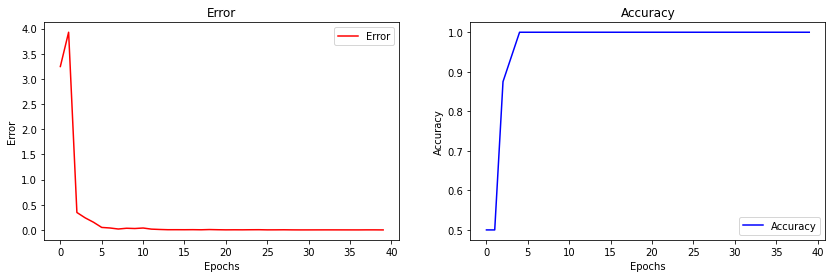

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Widget enablement
global model_initialised, model_trainable, model_trained
model_initialised = False  ; model_trainable = False ; model_trained = False;

# Clear the decks
rem_dir(image_save_path)
v_box_classes.children = []
clear_output()

# Display
display(css_element, v_box_main, gridbox, btn_stop_video) 

# Ensure logs visible in tab
tab_bar = colab_widgets.TabBar(['Main', 'Logging'])
with tab_bar.output_to(0, select=True):
    print('Click on "Logging" tab to see logs')
with tab_bar.output_to(1, select=False):
    display(widget_output)

# Load pre-trained CNN, in background
log_msg(f'Loading pre-trained CNN, in background')
init_load_weights_background(verbose=True)

log_msg(f'Fin layout')